In [ ]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu', weight_decay=1e-5):
    x = Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    
    if activation:
        x = Activation(activation)(x)
    
    return x

def sepconv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu', weight_decay=1e-5, depth_multiplier=1):
    x = SeparableConv2D(filters, kernel_size, padding=padding, strides=strides, depth_multiplier=depth_multiplier, depthwise_regularizer=l2(weight_decay), pointwise_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    
    if activation:
        x = Activation(activation)(x)
    
    return x

def Xception(model_input, classes):
    ## Entry flow
    x = conv2d_bn(model_input, 32, (3, 3), strides=2) # (299, 299, 3) -> (150, 150, 32)
    x = conv2d_bn(x, 64, (3, 3))

    for fliters in [128, 256, 728]: # (75, 75, 64) -> (75, 75, 128) -> (38, 38, 256) -> (19, 19, 728)
        residual = conv2d_bn(x, fliters, (1, 1), strides=2, activation=None)
        
        x = Activation(activation='relu')(x)
        x = sepconv2d_bn(x, fliters, (3, 3))
        x = sepconv2d_bn(x, fliters, (3, 3), activation=None)
        x = MaxPooling2D((3, 3), padding='same', strides=2)(x)
        
        x = Add()([x, residual])
        
        
    ## Middle flow
    for i in range(8): # (19, 19, 728)
        residual = x
        
        x = Activation(activation='relu')(x)
        x = sepconv2d_bn(x, 728, (3, 3))
        x = sepconv2d_bn(x, 728, (3, 3))
        x = sepconv2d_bn(x, 728, (3, 3), activation=None)
        
        x = Add()([x, residual])
        
        
    ## Exit flow
    residual = conv2d_bn(x, 1024, (1, 1), strides=2, activation=None) # (19, 19, 728) -> (10, 10, 1024)
        
    x = Activation(activation='relu')(x)
    x = sepconv2d_bn(x, 728, (3, 3))
    x = sepconv2d_bn(x, 1024, (3, 3), activation=None) # (19, 19, 728) -> (19, 19, 1024)
    x = MaxPooling2D((3, 3), padding='same', strides=2)(x) # (19, 19, 1024) -> (10, 10, 1024)
    
    x = Add()([x, residual])
    
    x = sepconv2d_bn(x, 1536, (3, 3))
    x = sepconv2d_bn(x, 2048, (3, 3))

    x = GlobalAveragePooling2D()(x)
    
    ## Optinal fully-connected layers
    '''
    x = Dense(4096)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Dense(4096)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    '''
    
    x = Dropout(0.5)(x)
    
    model_output = Dense(classes, activation='softmax')(x)

    model = Model(model_input, model_output, name='Xception')
    
    return model

from keras.models import Model, Input
from keras.layers import Conv2D, SeparableConv2D, Dense, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, BatchNormalization, Dropout
from keras.layers import Add
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.datasets import cifar10

import numpy as np
import keras.backend as K
from tqdm import tqdm
import cv2

# def Upscaling_Data(data_list, reshape_dim):
#     ...

# def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu', weight_decay=1e-5):
#     ...
    
# def sepconv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu', weight_decay=1e-5, depth_multiplier=1):
# 	...

# def Xception(model_input, classes):
# 	...
    
def Upscaling_Data(imgs, input_shape):
    new_imgs = []
    for img in tqdm(imgs):
        img = cv2.resize(img, dsize=(input_shape[0],input_shape[1]))
        new_imgs.append(img)
    
    return np.array(new_imgs)

class LearningRateSchedule(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1)%2 == 0:
            lr = K.get_value(self.model.optimizer.lr)
            K.set_value(self.model.optimizer.lr, lr*0.94)

input_shape = (299, 299, 3)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train[:10000]
y_train = y_train[:10000]

x_train = Upscaling_Data(x_train, input_shape)
x_test = Upscaling_Data(x_test, input_shape)

# x_train = x_train.astype('float32')/255.
# x_test = x_test.astype('float32')/255.

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

classes = 10

model_input = Input( shape=input_shape )

model = Xception(model_input, 10)

optimizer = SGD(lr=0.045, momentum=0.9)
callbacks_list = [LearningRateSchedule()]

model.compile(optimizer, loss='categorical_crossentropy', metrics=['acc'])

model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=callbacks_list)

170500096/170498071 [==============================] - 4s 0us/step


100%|██████████| 10000/10000 [00:01<00:00, 7172.85it/s]


Epoch 1/100
 45/250 [====>.........................] - ETA: 3:49 - loss: 4.0225 - acc: 0.1542

KeyboardInterrupt: ignored

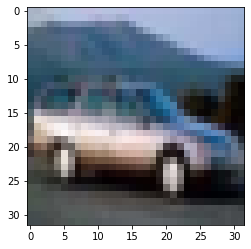

In [ ]:
x_train.shape
import matplotlib.pyplot as plt

plt.imshow(x_train[4])

In [ ]:
from keras.models import Model, Input
from keras.layers import Conv2D, SeparableConv2D, Dense, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, BatchNormalization, Dropout
from keras.layers import Add
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.datasets import cifar10

import numpy as np
import keras.backend as K
from tqdm import tqdm
import cv2

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
from keras.models import Sequential

In [ ]:
import keras
m = Sequential()
m.add(keras.applications.Xception(input_shape=input_shape))
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 1000)              22910480  
Total params: 22,910,480
Trainable params: 22,855,952
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
Model( )